In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kendalltau
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os
import sys

script_dir = os.path.dirname(os.getcwd()) 
parent_dir = os.path.join(script_dir)
sys.path.append(parent_dir)  

from utils import compute_metrics

In [2]:
df = pd.read_csv('mnsol_summary.csv')
df

,EXP,OpenFF/TIP3P,ML/MM-ME,QM7-Species,Bespoke-Iter1-Species,Bespoke-Iter2-Species,Patched-Iter1-Species,Patched-Iter2-Species,Patched-Iter2-Refereence,Patched-Iter2-Species-LJExp,LJ-MBIS
0,2.33,2.75,2.77,-1.17,1.34,1.33,1.13,1.21,1.32,2.24,1.19
1,2.89,3.05,2.87,-1.98,0.81,0.83,0.67,0.71,0.80,2.29,0.80
2,-0.87,-1.04,-1.07,0.57,-1.81,-1.96,-1.85,-1.84,-1.86,-1.05,-2.68
3,-2.39,-3.62,-3.60,-1.03,-3.69,-3.86,-3.50,-3.51,-3.78,-2.26,-4.07
4,-6.31,-6.40,-6.84,2.28,-9.98,-10.78,-8.47,-8.26,-7.78,-6.82,-7.58
5,-5.11,-3.93,-3.78,-3.17,-7.64,-7.69,-6.67,-6.48,-6.22,-5.18,-4.66
6,-5.87,-5.42,-6.56,-3.25,-8.41,-8.33,-7.93,-7.90,-8.09,-5.94,-6.18
7,-6.70,-6.97,-6.90,-8.31,-10.00,-9.71,-9.52,-9.32,-9.70,-7.01,-6.03
8,-5.05,-3.82,-3.78,-0.41,-5.04,-5.23,-6.08,-5.81,-5.75,-4.95,-5.06
9,-2.57,-3.11,-3.34,-4.44,-6.39,-6.22,-5.08,-4.58,-4.61,-2.46,-4.27


In [3]:
eps_07 = [
    1.74, 1.47, -1.19, -2.64, -7.20, -5.22, -6.42, -8.62, -4.83, -3.63, 
    -5.00, -3.31, -2.46, -10.48, -5.26, -3.80, -6.11, -10.32, -0.25, -1.83
]

eps_08 = [
    1.51, 1.20, -1.40, -2.89, -7.20, -5.62, -6.95, -8.62, -5.12, -3.94, 
    -5.33, -3.63, -2.83, -11.09, -5.52, -4.08, -6.11, -10.83, -0.52, -2.09
]

eps_09 = [
    1.39, 1.00, -1.61, -3.18, -7.69, -6.00, -7.43, -8.92, -5.46, -4.33, 
    -5.67, -3.97, -3.15, -11.56, -5.90, -4.44, -6.53, -11.54, -0.69, -2.38
]

molecule = [
    'n-pentane', 'n-octane', 'benzene', 'naphthalene', 'water', 'methanol', 
    'o-cresol', 'aceticacid', '1_4-dioxane', 'methylpentanoate', 'methylbenzoate', 
    '2-pentanone', 'ethylphenylether', 'm-hydroxybenzaldehyde', 'acetonitrile', 
    'pyridine', 'aniline', 'benzamide', '1-propanethiol', 'thioanisole'
]

# add as a column
df['eps_0.7'] = eps_07
df['eps_0.8'] = eps_08
df['eps_0.9'] = eps_09
df['eps_1.0'] = df['Patched-Iter2-Species']
df['molecule'] = molecule

df_eff = df[['molecule', 'EXP', 'eps_0.7', 'eps_0.8', 'eps_0.9', 'eps_1.0']]
df_eff

,molecule,EXP,eps_0.7,eps_0.8,eps_0.9,eps_1.0
0,n-pentane,2.33,1.74,1.51,1.39,1.21
1,n-octane,2.89,1.47,1.20,1.00,0.71
2,benzene,-0.87,-1.19,-1.40,-1.61,-1.84
3,naphthalene,-2.39,-2.64,-2.89,-3.18,-3.51
4,water,-6.31,-7.20,-7.20,-7.69,-8.26
5,methanol,-5.11,-5.22,-5.62,-6.00,-6.48
6,o-cresol,-5.87,-6.42,-6.95,-7.43,-7.90
7,aceticacid,-6.70,-8.62,-8.62,-8.92,-9.32
8,1_4-dioxane,-5.05,-4.83,-5.12,-5.46,-5.81
9,methylpentanoate,-2.57,-3.63,-3.94,-4.33,-4.58


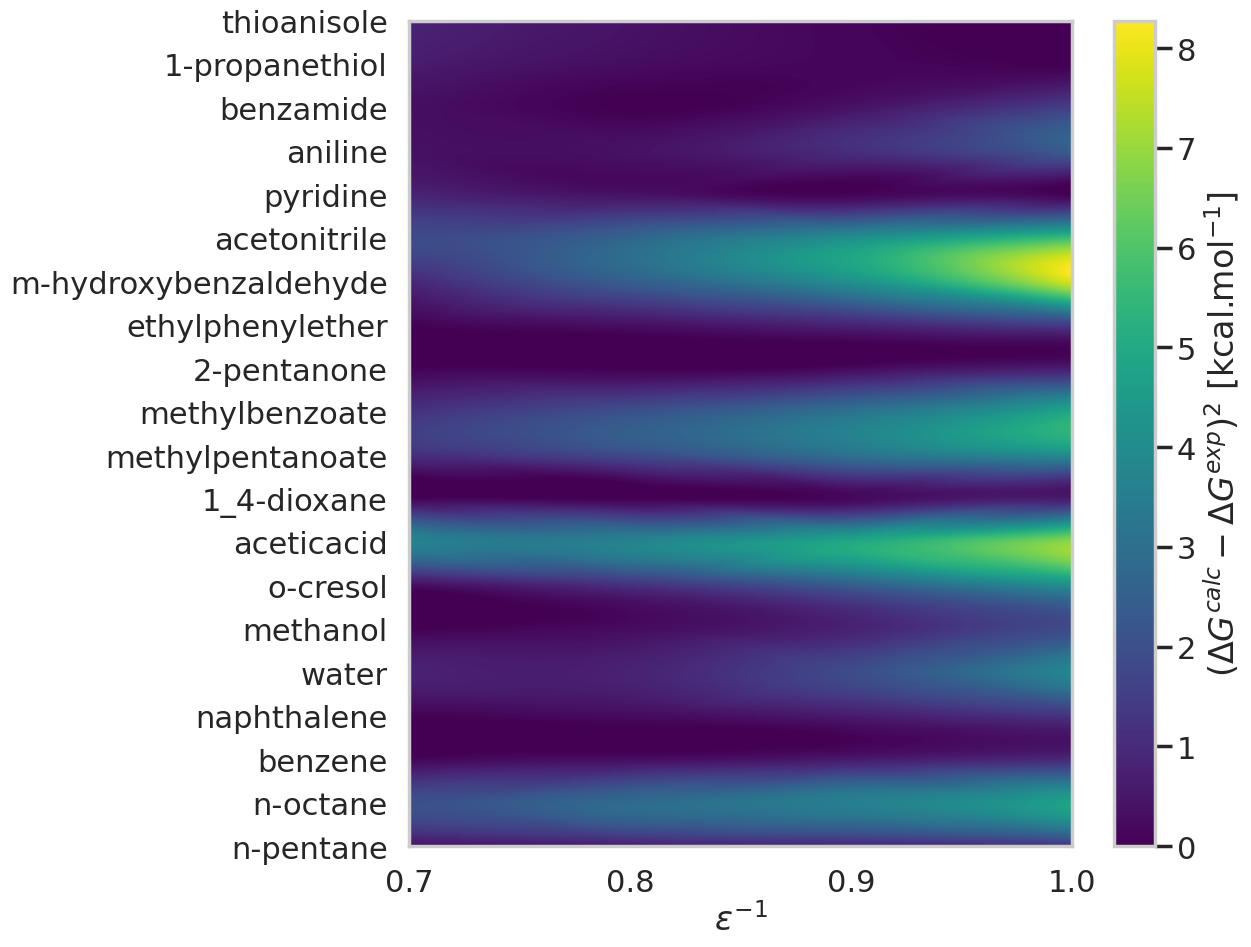

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import seaborn as sns

# Set Seaborn style
sns.set(style="whitegrid", palette="colorblind", context="poster")

#sns.set(style="whitegrid", font_scale=1.2, palette="colorblind")


# Calculate mean signed errors for each molecule and epsilon
errors = {
    'molecule': [],
    'eps_0.7': [],
    'eps_0.8': [],
    'eps_0.9': [],
    'eps_1.0': []
}

for index, row in df_eff.iterrows():
    errors['molecule'].append(row['molecule'])
    errors['eps_0.7'].append(row['eps_0.7'] - row['EXP'])
    errors['eps_0.8'].append(row['eps_0.8'] - row['EXP'])
    errors['eps_0.9'].append(row['eps_0.9'] - row['EXP'])
    errors['eps_1.0'].append(row['eps_1.0'] - row['EXP'])

# Create a DataFrame for interpolation
heatmap_df = pd.DataFrame(errors)
heatmap_df.set_index('molecule', inplace=True)

# Prepare data for interpolation
values = heatmap_df.values
x_labels = ['0.7', '0.8', '0.9', '1.0']  # Include eps_1.0 in x_labels
y_labels = np.arange(len(heatmap_df))  # y positions for molecules

# Define grid for interpolation
grid_x = np.linspace(0, len(x_labels) - 1, 2500) 
grid_y = np.linspace(0, len(y_labels), 2500) 
grid_x, grid_y = np.meshgrid(grid_x, grid_y)

# Flatten the original data for interpolation
points = np.array([[j, i] for i in range(len(y_labels)) for j in range(len(x_labels))])  
values_flat = values.flatten()
values_flat = values_flat ** 2

# Perform the interpolation
grid_z = griddata(points, values_flat, (grid_x, grid_y), method='cubic')

# Create the plot
plt.figure(figsize=(13, 10))
plt.imshow(grid_z, extent=[0, len(x_labels) - 1, 0, len(y_labels)],  # y limits from 0 to number of molecules
           aspect='auto', cmap='viridis', interpolation='antialiased', origin='lower')

# Add color bar
#plt.colorbar(label=r'$\left( \Delta G^{ML/MM}_{vac \rightarrow sol}-\Delta G^{EXP} \right)^2$ [kcal.mol$^{-1}$]')
plt.colorbar(label=r'$\left( \Delta G^{calc}-\Delta G^{exp} \right)^2$ [kcal.mol$^{-1}$]')

plt.clim(vmin=0)
plt.xticks(ticks=np.arange(len(x_labels)), labels=x_labels) 
plt.yticks(ticks=np.arange(len(y_labels)), labels=heatmap_df.index) 
plt.xlabel(r'$\epsilon^{-1}$')
plt.ylim(0, len(y_labels)-1)
plt.grid(False)
plt.tight_layout()
plt.savefig('fig5_eps_imshow.pdf', bbox_inches='tight', dpi=300, transparent=True)
plt.show()

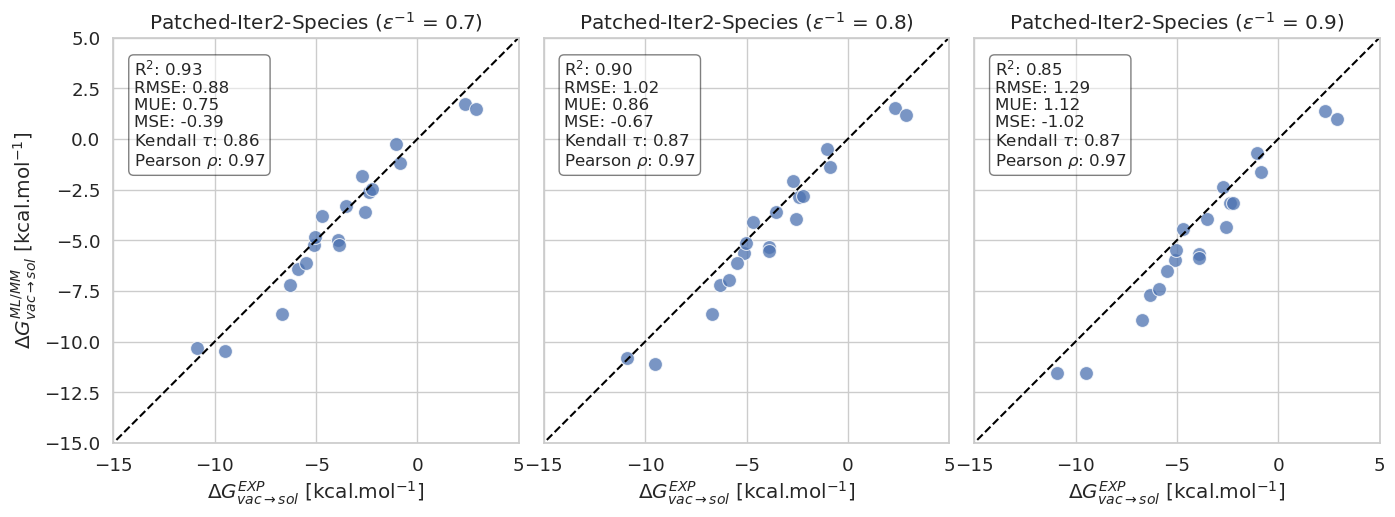

In [5]:
sns.set(style='whitegrid', font_scale=1.2)

columns_to_plot = df_eff.columns[2:-1]  # Exclude 'EXP'
num_plots = len(columns_to_plot)
ncols = 4
nrows = (num_plots + ncols - 1) // ncols 

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 5 * nrows), sharex=True, sharey=True)

axes = axes.flatten()
xx = np.linspace(-100, 100, 100)
yy = xx

for i, column in enumerate(columns_to_plot):
    x = df_eff['EXP']
    y = df_eff[column]

    # Calculate statistics
    mue, mse, kendall, pearson, r2, rmse = compute_metrics(x, y)
  
    sns.lineplot(ax=axes[i], x=xx, y=yy, color='black', linestyle='--')
    sns.scatterplot(ax=axes[i], x=x, y=y, s=100, alpha=0.75)
    axes[i].set_title(r'Patched-Iter2-Species ($\epsilon^{-1}$ = ' + column.split('_')[1] + ')')
    axes[i].set_ylabel(r'$\Delta G^{ML/MM}_{vac \rightarrow sol}$ [kcal.mol$^{-1}$]')
    axes[i].set_xlabel(r'$\Delta G^{EXP}_{vac \rightarrow sol}$ [kcal.mol$^{-1}$]')
    
    stats_text = f"RMSE: {rmse:.2f}\nMSE: {mse:.2f}\nKendall's Tau: {kendall:.2f}\nR$^2$: {r2:.2f}\nPearson: {pearson:.2f}"

    axes[i].text(
        0.05,
        0.95,
        f"R$^2$: {r2:.2f}\nRMSE: {rmse:.2f} \nMUE: {mue:.2f}\nMSE: {mse:.2f}\nKendall $\\tau$: {kendall:.2f}\nPearson $\\rho$: {pearson:.2f}",
        transform=axes[i].transAxes,
        fontsize=12,
        verticalalignment="top",
        horizontalalignment="left",
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3",alpha=0.5),
    )
    axes[i].grid(True)
    axes[i].set_xlim(-15, 5)
    axes[i].set_ylim(-15, 5)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

for ax in axes:
    ax.set_aspect('equal', 'box')

plt.tight_layout(pad=0)  
plt.savefig('fig5_ahfe_benchmark_eps.pdf', bbox_inches='tight', dpi=300)
plt.show()